<a href="https://colab.research.google.com/github/ashmibanerjee/email-automation/blob/main/Email_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial: How to Send Automated Emails using Python**


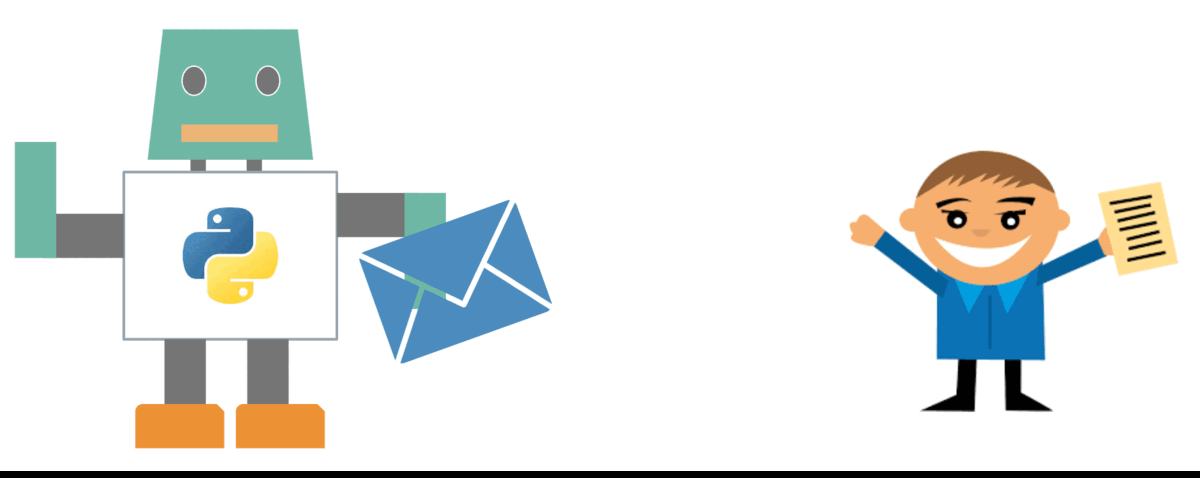



## **Step 0: Prerequisites**

### **Mounting Google Drive and setting up the path**

In the following step we need to mount Google Drive to the right folder where the colab notebook recides.

In this case, I have used the following location for my notebook

`/content/drive/My Drive/personal/Events & Presentations/PyconPortugal22/email-automation`

You can use any location of your choice but make sure you adjust the path accordingly.

In [1]:
import os
from os.path import join
from google.colab import drive

ROOT = "/content/drive/"
drive.mount(ROOT)

%cd drive/My\ Drive/personal/Talks/PyconPortugal22/email-automation/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/personal/Talks/PyconPortugal22/email-automation


### **Email Validator**

The following is a basic email validator function using simple regex expressions. This makes sure that the (recipient's) email entered by user is valid.

In [2]:
import re

In [3]:
regex = re.compile(r"([-!#-'*+/-9=?A-Z^-~]+(\.[-!#-'*+/-9=?A-Z^-~]+)*|\"([]!#-[^-~ \t]|(\\[\t -~]))+\")@([-!#-'*+/-9=?A-Z^-~]+(\.[-!#-'*+/-9=?A-Z^-~]+)*|\[[\t -Z^-~]*])")

def isValid(email):
    if re.fullmatch(regex, email):
        print("Valid email")
        return True
    print("Invalid email")
    return False

## **Step 1: Getting Sender Info from Config File**


We use a `ConfigParser` to read from the `config` file `settings.ini` which is located in the same directory as the notebook. 

Create a file called `settings.ini` in the same directory as the notebook and fill it up with the sender information as follows. You can learn about generating `App Passwords` with your `Gmail` [here](https://support.google.com/accounts/answer/185833?hl=en).


```
[SenderAccountInfo]
NAME=John Doe
EMAIL=john.doe@gmail.com
CC=another.doe@gmail.com
APP_PASSWORD=ARanDomPassWord

```


***Note: The `settings.ini` contain confidential information such as senders email, password, etc. and should not be version controlled or shared in public.***

In [4]:
import configparser

In [5]:
config = configparser.ConfigParser()
config.read("settings.ini")

['settings.ini']

In [6]:
sender_email = config["SenderAccountInfo"]["EMAIL"]
sender_name = config["SenderAccountInfo"]["NAME"]
cc = config["SenderAccountInfo"]["CC"]
app_password = config["SenderAccountInfo"]["APP_PASSWORD"]

## **Step 2: Get email Subject**

We define the subject of our email here. 

In [7]:
def get_mail_subject():
    return "Testing Automated Emails"

## **Step 3: Get email Body**
The text for the email body is defined here.

In [8]:
def get_mail_body(receiver_first_name: str, sender_name: str):
    msg_body = f"Dear {receiver_first_name}, \nThis email was automatically sent using Python. \n" \
               f"Hope you like it. \n Cheers, \n {sender_name}  "
    return msg_body

## **Step 4: Get email Attachment**
If your email has attachments, this is the time to *attach* them.

Again, make sure you have file path correctly set 😉

In [9]:
def get_email_attachment(file_name: str = "test_image.png"):
    file_path = os.getcwd() + "/assets/"
    attachment_file = file_path + file_name
    return attachment_file

## **Step 5: Get Recipient Info**

Here, we ask the user *(recipient)* to enter their information.
It keeps asking the user for a valid email until they enter one.

In [11]:
receiver_name = input("Enter recipient full name (First name Last Name): ")

try:
    receiver_first_name, receiver_last_name = receiver_name.split(" ")
except ValueError:
    receiver_first_name, receiver_last_name = receiver_name, ""

while True:
    receiver_email = input("Enter recipient Email: ")
    if isValid(receiver_email):
        break

print(f"\n Recipient Infos: \n\tFirst Name: {receiver_first_name} \n\tLast Name: {receiver_last_name} \n\tEmail: {receiver_email}")

Enter recipient full name (First name Last Name): sfgt
Enter recipient Email: ashmi.banerjee@tum.de
Valid email

 Recipient Infos: 
	First Name: sfgt 
	Last Name:  
	Email: ashmi.banerjee@tum.de


## **Step 6: Prepare Email**
Now that we have all the information about the email (its subject, body, recipient details, etc.) ready, it's time for us to set the stage for summarising it and creating the `MIMEMultipart` and `MIMEBase` instances along with their payloads.

An e-mail message consists of `headers` (e.g. `"From"`, `"To"`, `"Subject"` etc.) and `body` (src: [RFC 822, section 3.1](https://www.rfc-editor.org/rfc/rfc822#section-3.1)).

The `body` of the message is, by default, treated as `plain ASCII text`.

In this section we do the following:

* `[Line 1]` - Create an instance of `MIMEMultipart()`
* `[Line 3-6]` - Fill up the header details of the `MIMEMultipart()` instance *i.e.* `email`
* `[Line 9]` - Get the email `body`
* `[Line 12]` - Attach the email `body` to the email instance
* `[Line 16-25]` - Attach the `attachment file` to the email and then encode it to `base64`
* `[Line 27]` - Add the `attachment file` as a `header` and finally attach it to `email` (`MIMEMultipart()` instance)
* `[Line 32]` - Convert the `MIMEMultipart()` to a `string`

In [12]:
import smtplib
from email import encoders
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

In [13]:
email = MIMEMultipart()

# define the email headers 
email["From"] = sender_email
email["To"] = receiver_email
email["Subject"] = get_mail_subject()

# get the email body
email_body = get_mail_body(receiver_first_name, sender_name)

# Add body and attachment to email
email.attach(MIMEText(email_body, "html"))

# Add email attachment
attachment_file_name = "test_image.png"
attachment = open(get_email_attachment(), "rb")

# instance of MIMEBase and named as p
p = MIMEBase('application', 'octet-stream')

 # To change the payload into encoded form
p.set_payload(attachment.read())

# encode into base64
encoders.encode_base64(p)

p.add_header('Content-Disposition', "attachment; filename= %s" % attachment_file_name)

# attach the instance 'p' to instance 'msg'
email.attach(p)

email = email.as_string()

## **Step 7: Send Email**


We are just one step away from our goal now !!

In this phase, we do the following

* `[Line 3]` - Open an `SMTP Gmail` session using port `587` 
* `[Line 6]` - Enable the security using `starttls()`
* `[Line 9]` - Login using `sender email` and `app password`
* `[Line 12]` - Send the email to the `recipient`
* `[Line 15]` - Close the session

In [14]:
# Create SMTP session for sending the mail
# use gmail with port
session = smtplib.SMTP('smtp.gmail.com', 587)

# enable security
session.starttls()

# login with mail_id and password
session.login(sender_email, app_password)

# send email
session.sendmail(sender_email, receiver_email, email)

# quit session
session.quit()

(221,
 b'2.0.0 closing connection r24-20020ab070d8000000b0039f721a88b4sm239579ual.9 - gsmtp')

## **Step 8: Celebrate !!** 🎊

We have accomplished our goal of being able to send emails automatically using Python! *yay* !!

In [15]:
from datetime import datetime

In [16]:
print(f"Mail Sent to {receiver_name} at {receiver_email} at {datetime.now()}")

Mail Sent to sfgt at ashmi.banerjee@tum.de at 2022-09-02 12:03:29.017276
